In [1]:
import pandas as pd
from collections import Counter

In [2]:
df = pd.read_csv("/content/corpus_dir-max_num_gloss=5-augmented.csv")
df.head(10)

,id,sentence,sense_keys,glosses,targets
0,d000.s000.t000,How [TGT] long [TGT] has it been since you rev...,"['long%5:00:00:abundant:00', 'long%3:00:01::',...",['having or being more than normal or necessar...,[2]
1,d000.s000.t001,How long has it [TGT] been [TGT] since you rev...,"['be%2:42:04::', 'be%2:42:01::', 'be%2:42:08::...","['happen, occur, take place', 'have life, be a...",[4]
2,d000.s000.t002,How long has it been since you [TGT] reviewed ...,"['review%2:31:01::', 'review%2:31:02::', 'revi...","['look back upon (a period of time, sequence o...",[3]
3,d000.s000.t003,How long has it been since you reviewed the [T...,"['objective%1:09:00::', 'objective%1:06:00::']",['the goal intended to be attained (and which ...,[0]
4,d000.s000.t004,How long has it been since you reviewed the ob...,"['benefit%1:07:00::', 'benefit%1:10:00::', 'be...","['something that aids or promotes well-being',...",[2]
5,d000.s000.t005,How long has it been since you reviewed the ob...,"['service%1:04:04::', 'service%1:04:07::', 'se...",['the act of delivering a writ or summons upon...,[1]
6,d000.s000.t006,How long has it been since you reviewed the ob...,"['program%1:04:00::', 'program%1:10:02::', 'pr...",['a performance (or series of performances) at...,[3]
7,d000.s001.t000,Have you [TGT] permitted [TGT] it to become a ...,"['permit%2:41:00::', 'permit%2:32:06::', 'perm...",['make it possible through a specific action o...,[0]
8,d000.s001.t001,Have you permitted it to [TGT] become [TGT] a ...,"['become%2:42:03::', 'become%2:30:00::', 'beco...","['enhance the appearance of', 'enter or assume...",[3]
9,d000.s001.t002,Have you permitted it to become a [TGT] giveaw...,"['giveaway%1:10:00::', 'giveaway%1:21:00::', '...","['an unintentional disclosure', 'a gift of pub...",[1]


In [3]:
# Supposons que 'df' est votre dataframe
df_filtered = df[df['sense_keys'].apply(lambda x: len(eval(x)) >= 3)]

# Nombre total de lignes avant le filtrage
total_rows = len(df)

# Nombre de lignes après le filtrage
filtered_rows = len(df_filtered)

# Pourcentage de lignes conservées
percentage_kept = (filtered_rows / total_rows) * 100

print(f"Nombre total de lignes : {total_rows}")
print(f"Nombre de lignes conservées : {filtered_rows}")
print(f"Pourcentage de lignes conservées : {percentage_kept:.2f}%")

Nombre total de lignes : 263632
Nombre de lignes conservées : 179413
Pourcentage de lignes conservées : 68.05%


In [4]:
# Vérifiez les 5 premières lignes
print(df_filtered["glosses"].head())

# Vérifiez les valeurs nulles ou incorrectes
print(df_filtered["glosses"].isnull().sum())  # Nombre de glosses nulles
print(df_filtered["glosses"].apply(lambda x: isinstance(x, list)).value_counts())  # Vérifiez si ce sont bien des listes

0    ['having or being more than normal or necessar...
1    ['happen, occur, take place', 'have life, be a...
2    ['look back upon (a period of time, sequence o...
4    ['something that aids or promotes well-being',...
5    ['the act of delivering a writ or summons upon...
Name: glosses, dtype: object
0
glosses
False    179413
Name: count, dtype: int64


In [5]:
print(len(df))
print(len(df_filtered))

263632
179413


In [6]:
df = df_filtered

In [7]:
print(len(df))
print(len(df_filtered))

179413
179413


In [8]:
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

def extract_target_word(sentence):
    """Extrait le mot cible entre les balises [TGT]"""
    pattern = r'\[TGT\](.*?)\[TGT\]'
    matches = re.findall(pattern, sentence)
    return matches[0].strip() if matches else None

def parse_targets(targets_str):
    """Parse la chaîne de caractères des cibles en liste d'entiers"""
    cleaned = targets_str.strip('[]')
    return [int(x.strip()) for x in cleaned.split(',')]

def analyze_sense_distribution(df):
    """Analyse la distribution des sens pour chaque mot cible"""
    word_sense_distribution = defaultdict(lambda: defaultdict(int))

    # Calculer la distribution
    for index, row in df.iterrows():
        word = row['target_word']
        sense_indices = parse_targets(row['targets'])
        for sense_index in sense_indices:
            word_sense_distribution[word][sense_index] += 1

    # Calculer des statistiques
    word_stats = {}
    for word in word_sense_distribution:
        distribution = word_sense_distribution[word]
        total_occurrences = sum(distribution.values())
        n_senses = len(distribution)
        most_common_sense = max(distribution.items(), key=lambda x: x[1])

        word_stats[word] = {
            'total_occurrences': total_occurrences,
            'number_of_senses': n_senses,
            'most_common_sense': most_common_sense[0],
            'most_common_sense_count': most_common_sense[1],
            'distribution': dict(distribution)
        }

    return word_stats

def plot_sense_distribution(word_stats, top_n=10):
    """Visualise la distribution des sens pour les top_n mots les plus fréquents"""
    # Trier les mots par nombre total d'occurrences
    sorted_words = sorted(word_stats.items(),
                        key=lambda x: x[1]['total_occurrences'],
                        reverse=True)[:top_n]

    fig, ax = plt.subplots(figsize=(12, 6))

    x_pos = 0
    tick_positions = []
    tick_labels = []

    for word, stats in sorted_words:
        distribution = stats['distribution']
        positions = [x_pos + i for i in range(len(distribution))]
        tick_positions.extend(positions)
        tick_labels.extend([f"{word}_{i}" for i in distribution.keys()])

        plt.bar(positions, distribution.values())
        x_pos += len(distribution) + 1

    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    plt.ylabel('Nombre d\'occurrences')
    plt.title('Distribution des sens par mot')
    plt.tight_layout()

    return plt

# Utilisation
def main(df):
    # Ajouter la colonne des mots cibles
    df['target_word'] = df['sentence'].apply(extract_target_word)

    # Analyser la distribution
    word_stats = analyze_sense_distribution(df)

    # Afficher les statistiques pour les 5 premiers mots
    for word in list(word_stats.keys())[:5]:
        print(f"\nMot: {word}")
        print(f"Nombre total d'occurrences: {word_stats[word]['total_occurrences']}")
        print(f"Nombre de sens différents: {word_stats[word]['number_of_senses']}")
        print(f"Sens le plus commun: {word_stats[word]['most_common_sense']} "
              f"({word_stats[word]['most_common_sense_count']} occurrences)")
        print("Distribution complète:", word_stats[word]['distribution'])

    # Créer la visualisation
    plot_sense_distribution(word_stats)

    return word_stats


Mot: long
Nombre total d'occurrences: 187
Nombre de sens différents: 5
Sens le plus commun: 4 (53 occurrences)
Distribution complète: {2: 27, 1: 32, 4: 53, 3: 40, 0: 35}

Mot: been
Nombre total d'occurrences: 622
Nombre de sens différents: 5
Sens le plus commun: 1 (149 occurrences)
Distribution complète: {4: 126, 3: 120, 1: 149, 0: 109, 2: 118}

Mot: reviewed
Nombre total d'occurrences: 12
Nombre de sens différents: 5
Sens le plus commun: 2 (5 occurrences)
Distribution complète: {3: 1, 1: 2, 2: 5, 4: 1, 0: 3}

Mot: benefit
Nombre total d'occurrences: 14
Nombre de sens différents: 3
Sens le plus commun: 2 (6 occurrences)
Distribution complète: {2: 6, 0: 5, 1: 3}

Mot: service
Nombre total d'occurrences: 41
Nombre de sens différents: 5
Sens le plus commun: 0 (13 occurrences)
Distribution complète: {1: 9, 2: 9, 3: 7, 0: 13, 4: 3}


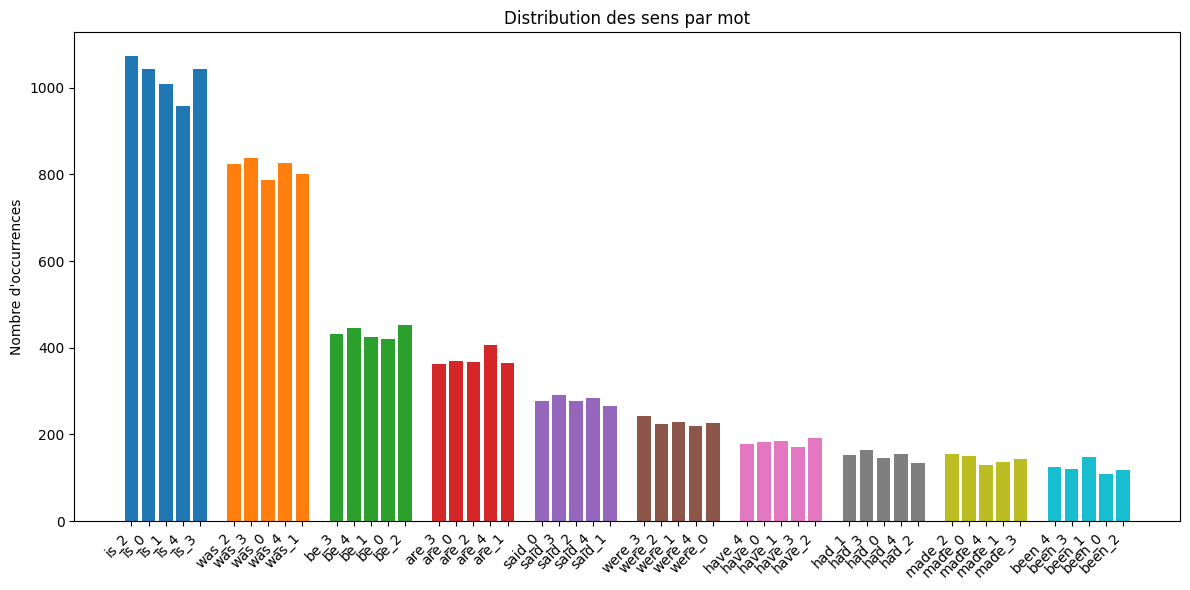

In [9]:
word_stats = main(df)

In [10]:
def analyze_word_occurrences(df, word=None, occurrence_count=None, show_extremes=False):
    """
    Analyse les occurrences des mots dans le dataset avec différentes options

    Args:
        df: DataFrame source
        word: Mot spécifique à analyser (optionnel)
        occurrence_count: Nombre d'occurrences à rechercher (optionnel)
        show_extremes: Afficher les sens les plus/moins fréquents pour chaque mot
    """
    def get_word_sense_distribution(word_data):
        sense_count = defaultdict(int)
        for targets in word_data['targets']:
            for sense in eval(targets):
                sense_count[sense] += 1
        return dict(sense_count)

    def print_word_details(word_data, distribution):
        print(f"\nAnalyse pour le mot '{word_data['target_word'].iloc[0]}':")
        print(f"Nombre total d'occurrences: {len(word_data)}")

        # Afficher toutes les occurrences avec leurs détails
        print("\nDétails de chaque occurrence:")
        for idx, row in word_data.iterrows():
            print("\n-------------------")
            for column in df.columns:
                print(f"{column}: {row[column]}")

        if show_extremes:
            # Trouver et afficher le sens le plus/moins commun
            most_common = max(distribution.items(), key=lambda x: x[1])
            least_common = min(distribution.items(), key=lambda x: x[1])
            print(f"\nSens le plus commun: {most_common[0]} ({most_common[1]} occurrences)")
            print(f"Sens le moins commun: {least_common[0]} ({least_common[1]} occurrences)")

    # Cas 1: Analyser un mot spécifique
    if word is not None:
        word_data = df[df['target_word'] == word]
        if len(word_data) == 0:
            print(f"Aucune occurrence trouvée pour le mot '{word}'")
            return

        distribution = get_word_sense_distribution(word_data)
        print_word_details(word_data, distribution)

    # Cas 2: Rechercher les mots avec un certain nombre d'occurrences
    elif occurrence_count is not None:
        found_words = []
        for word in df['target_word'].unique():
            word_data = df[df['target_word'] == word]
            distribution = get_word_sense_distribution(word_data)

            # Vérifier si un des sens a exactement le nombre d'occurrences demandé
            if occurrence_count in distribution.values():
                found_words.append(word)
                print(f"\nMot trouvé: '{word}' avec {occurrence_count} occurrences pour au moins un sens")
                print_word_details(word_data, distribution)

        if not found_words:
            print(f"Aucun mot trouvé avec exactement {occurrence_count} occurrences pour un de ses sens")

    # Cas 3: Analyser tous les mots
    else:
        for word in df['target_word'].unique():
            word_data = df[df['target_word'] == word]
            distribution = get_word_sense_distribution(word_data)
            print_word_details(word_data, distribution)

In [ ]:
# Exemples d'utilisation:
"""
# Pour voir toutes les occurrences d'un mot spécifique avec ses sens extrêmes:
analyze_word_occurrences(df, word="reviewed", show_extremes=True)

# Pour trouver tous les mots qui ont un sens avec exactement 34 occurrences:
analyze_word_occurrences(df, occurrence_count=34)

# Pour voir tous les mots avec leurs sens extrêmes:
analyze_word_occurrences(df, show_extremes=True)
"""

In [11]:
# Pour voir toutes les occurrences d'un mot spécifique avec ses sens extrêmes:
analyze_word_occurrences(df, word="reviewed", show_extremes=True)


Analyse pour le mot 'reviewed':
Nombre total d'occurrences: 12

Détails de chaque occurrence:

-------------------
id: d000.s000.t002
sentence: How long has it been since you [TGT] reviewed [TGT] the objectives of your benefit and service program ?
sense_keys: ['review%2:31:01::', 'review%2:31:02::', 'review%2:32:00::', 'review%2:31:00::', 'review%2:31:04::']
glosses: ['look back upon (a period of time, sequence of events); remember', 'hold a review (of troops)', 'appraise critically', 'look at again; examine again', "refresh one's memory"]
targets: [3]
target_word: reviewed

-------------------
id: d036.s098.t002
sentence: Are annual marketing plans [TGT] reviewed [TGT] throughout your management group to get the perspective of all individuals and get everyone on the marketing team ?
sense_keys: ['review%2:31:01::', 'review%2:31:00::', 'review%2:31:02::', 'review%2:31:04::', 'review%2:32:00::']
glosses: ['look back upon (a period of time, sequence of events); remember', 'look at agai

In [29]:
from collections import defaultdict

def create_sense_mapping(df, word):
    """
    Crée une correspondance fixe entre les sense_keys et leurs définitions
    """
    # Prendre la première occurrence pour établir la correspondance initiale
    first_row = df[df['target_word'] == word].iloc[0]
    sense_keys = eval(first_row['sense_keys'])
    glosses = eval(first_row['glosses'])

    # Créer le dictionnaire de correspondance
    sense_mapping = {key: gloss for key, gloss in zip(sense_keys, glosses)}
    return sense_mapping

def analyze_word_senses_improved(df, word):
    """
    Analyse les sens d'un mot en maintenant une correspondance cohérente
    """
    word_data = df[df['target_word'] == word]

    # Créer la correspondance fixe sense_key -> définition
    sense_mapping = create_sense_mapping(df, word)

    # Dictionnaire pour compter les occurrences de chaque sense_key
    sense_counts = defaultdict(int)

    print(f"\nAnalyse détaillée pour le mot '{word}':")
    print("\nCorrespondance sense_key -> définition:")
    for key, gloss in sense_mapping.items():
        print(f"{key}: {gloss}")

    print("\nAnalyse des occurrences:")
    for idx, row in word_data.iterrows():
        target = eval(row['targets'])[0]  # L'index utilisé
        sense_keys = eval(row['sense_keys'])
        target_sense_key = sense_keys[target]  # Le sense_key effectivement utilisé

        print(f"\n{'='*50}")
        print(f"Phrase: {row['sentence']}")
        print(f"Target utilisé: {target}")
        print(f"Sense key: {target_sense_key}")
        print(f"Définition: {sense_mapping[target_sense_key]}")

        sense_counts[target_sense_key] += 1

    print("\nRésumé des occurrences par sens:")
    for sense_key, count in sorted(sense_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"\nSense key: {sense_key}")
        print(f"Définition: {sense_mapping[sense_key]}")
        print(f"Nombre d'occurrences: {count}")

    # Identifier les sens les plus et moins communs
    most_common = max(sense_counts.items(), key=lambda x: x[1])
    least_common = min(sense_counts.items(), key=lambda x: x[1])

    print("\nStatistiques finales:")
    print(f"Sens le plus commun: '{sense_mapping[most_common[0]]}' ({most_common[1]} occurrences)")
    print(f"Sens le moins commun: '{sense_mapping[least_common[0]]}' ({least_common[1]} occurrences)")

# Fonction pour chercher des occurrences spécifiques
def find_specific_occurrences(df, occurrence_count):
    """
    Trouve tous les mots qui ont un sens avec exactement le nombre d'occurrences spécifié
    """
    results = {}

    for word in df['target_word'].unique():
        word_data = df[df['target_word'] == word]
        sense_counts = defaultdict(int)

        for row in word_data.iterrows():
            target = eval(row[1]['targets'])[0]
            sense_counts[target] += 1

        # Vérifier si un des sens a le nombre d'occurrences recherché
        for sense, count in sense_counts.items():
            if count == occurrence_count:
                if word not in results:
                    results[word] = []
                results[word].append((sense, count))

    return results

In [30]:
# Pour analyser un mot spécifique
analyze_word_senses_improved(df, "been")


Analyse détaillée pour le mot 'been':

Correspondance sense_key -> définition:
be%2:42:04::: happen, occur, take place
be%2:42:01::: have life, be alive
be%2:42:08::: represent, as of a character on stage
be%2:42:07::: be identical or equivalent to
be%2:42:03::: have the quality of being; (copula, used with an adjective or a predicate noun)

Analyse des occurrences:

Phrase: How long has it [TGT] been [TGT] since you reviewed the objectives of your benefit and service program ?
Target utilisé: 4
Sense key: be%2:42:03::
Définition: have the quality of being; (copula, used with an adjective or a predicate noun)

Phrase: He might have [TGT] been [TGT] in collusion with Johnston on the fraud ; he might be Mrs. Meeker 's murderer or have played some part in her death .
Target utilisé: 3
Sense key: be%2:42:03::
Définition: have the quality of being; (copula, used with an adjective or a predicate noun)

Phrase: It would have [TGT] been [TGT] Hohlbein who handled her affairs .
Target utilisé:

KeyError: 'be%2:42:06::'

In [16]:
# Pour analyser un mot spécifique
analyze_word_senses_improved(df, "reviewed")


Analyse détaillée pour le mot 'reviewed':

Correspondance sense_key -> définition:
review%2:31:01::: look back upon (a period of time, sequence of events); remember
review%2:31:02::: hold a review (of troops)
review%2:32:00::: appraise critically
review%2:31:00::: look at again; examine again
review%2:31:04::: refresh one's memory

Analyse des occurrences:

Phrase: How long has it been since you [TGT] reviewed [TGT] the objectives of your benefit and service program ?
Target utilisé: 3
Sense key: review%2:31:00::
Définition: look at again; examine again

Phrase: Are annual marketing plans [TGT] reviewed [TGT] throughout your management group to get the perspective of all individuals and get everyone on the marketing team ?
Target utilisé: 1
Sense key: review%2:31:00::
Définition: look at again; examine again

Phrase: All comments concerning effectiveness and use of drugs have been carefully [TGT] reviewed [TGT] by a veterinary medical officer with FDA .
Target utilisé: 2
Sense key: re

In [14]:
# Pour trouver les mots avec un certain nombre d'occurrences
results = find_specific_occurrences(df, 34)
for word, senses in results.items():
    print(f"\nMot '{word}' a des sens avec {34} occurrences:")
    analyze_word_senses(df, word)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
--------------------------------------------------
Occurrence 217923:
Phrase: We know that in the early part of the century many Protestant congregations [TGT] took [TGT] positive action against members who transgressed the ethical codes to which the majority subscribed .
Target utilisé: 0
Définition correspondante: carry out
--------------------------------------------------
Occurrence 218020:
Phrase: In the latter year Samuel Hopkins , from whom the Hopkinsian strain of New England theology [TGT] took [TGT] its name , asked the Continental Congress to abolish slavery .
Target utilisé: 2
Définition correspondante: pick out, select, or choose from a number of alternatives
--------------------------------------------------
Occurrence 218024:
Phrase: As we have seen , Methodism early [TGT] took [TGT] a stand against slavery .
Target utilisé: 2
Définition correspondante: carry out
-------------------------------